In [ ]:
##Regime Detection of Apple

In [2]:
import pandas as pd
import pandas_datareader.data as web
import sklearn.mixture as mix

import numpy as np
import scipy.stats as scs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns
import missingno as msno
from tqdm import tqdm
p=print
import datetime

C:\Users\HP\AppData\Local\Temp/ipykernel_11804/1187959211.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime.today()


            TEDRATE  T10Y2Y  T10Y3M      AAPL      sret
2002-01-03     0.18    1.97    3.43  0.360552  0.011946
2002-01-04     0.18    1.99    3.46  0.362235  0.004656
2002-01-07     0.21    2.01    3.41  0.350155 -0.033916
2002-01-08     0.19    2.03    3.42  0.345721 -0.012746
2002-01-09     0.19    2.07    3.42  0.331042 -0.043387


<AxesSubplot:>

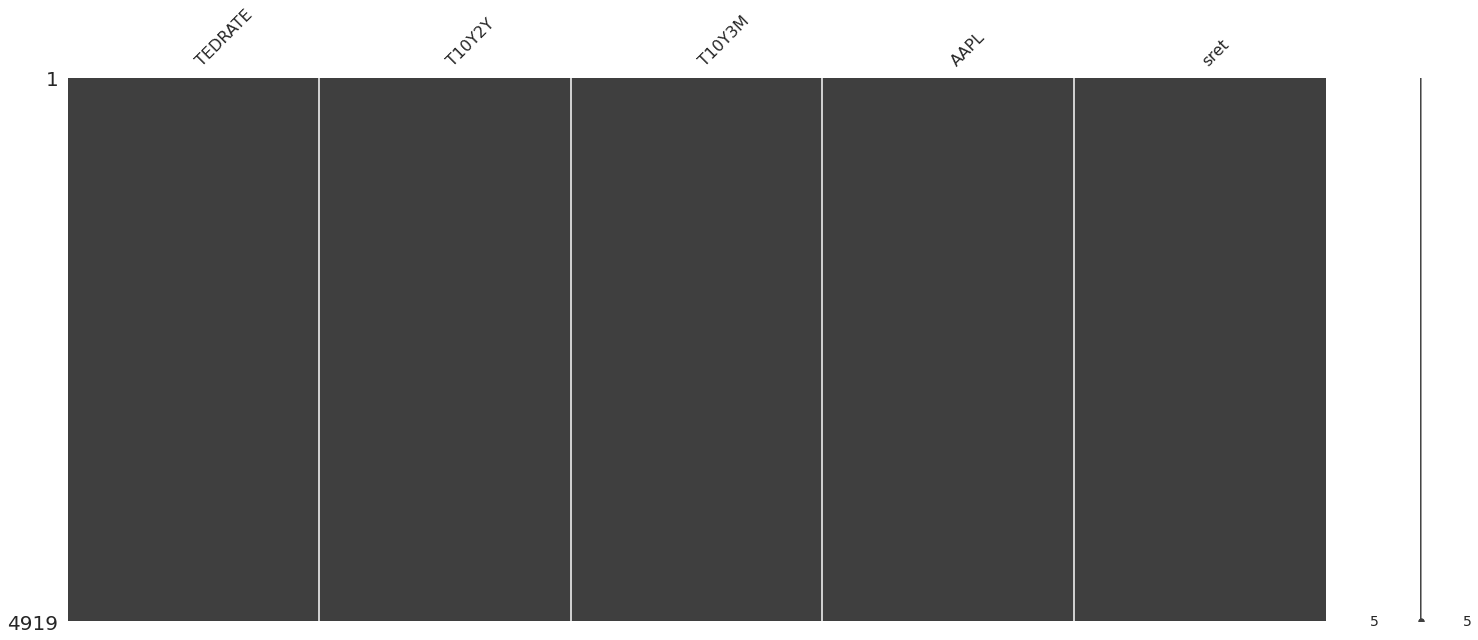

In [29]:
# get fed data

f1 = 'TEDRATE' # ted spread
f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
f3 = 'T10Y3M' # constant maturity 10yr - 3m

start = pd.to_datetime('2002-01-01')
end = pd.datetime.today()

mkt = 'AAPL'
MKT = (web.DataReader([mkt], 'yahoo', start, end)['Adj Close']
       .rename(columns={mkt:mkt})
       .assign(sret=lambda x: np.log(x[mkt]/x[mkt].shift(1)))
       .dropna())

data = (web.DataReader([f1, f2, f3], 'fred', start, end)
        .join(MKT, how='inner')
        .dropna()
       )

p(data.head())

# gives us a quick visual inspection of the data
msno.matrix(data)

Next we will use the sklearn's GaussianMixture to fit a model that estimates these regimes. We will explore mixture models in more depth in part 2 of this series. The important takeaway is that mixture models implement a closely related unsupervised form of density estimation. It makes use of the expectation-maximization algorithm to estimate the means and covariances of the hidden states (regimes). For now, it is ok to think of it as a magic button for guessing the transition and emission probabilities, and most likely path.

We have to specify the number of components for the mixture model to fit to the time series. In this example the components can be thought of as regimes. We will arbitrarily classify the regimes as High, Neutral and Low Volatility and set the number of components to three.

Means and vars of each hidden state
0th hidden state
mean =  [2.27723730e-01 2.04021876e+00 2.61233184e+00 7.91014566e-04]
var =  [4.30395204e-03 2.23040090e-01 4.07274702e-01 3.23204848e-04]

1th hidden state
mean =  [0.33897944 0.5236647  0.784171   0.00148548]
var =  [2.29812766e-02 1.99146324e-01 5.02041373e-01 3.08223754e-04]

2th hidden state
mean =  [1.06616393e+00 1.48817728e+00 1.95472199e+00 9.05984448e-04]
var =  [0.51434304 0.39514382 0.88054745 0.00138042]



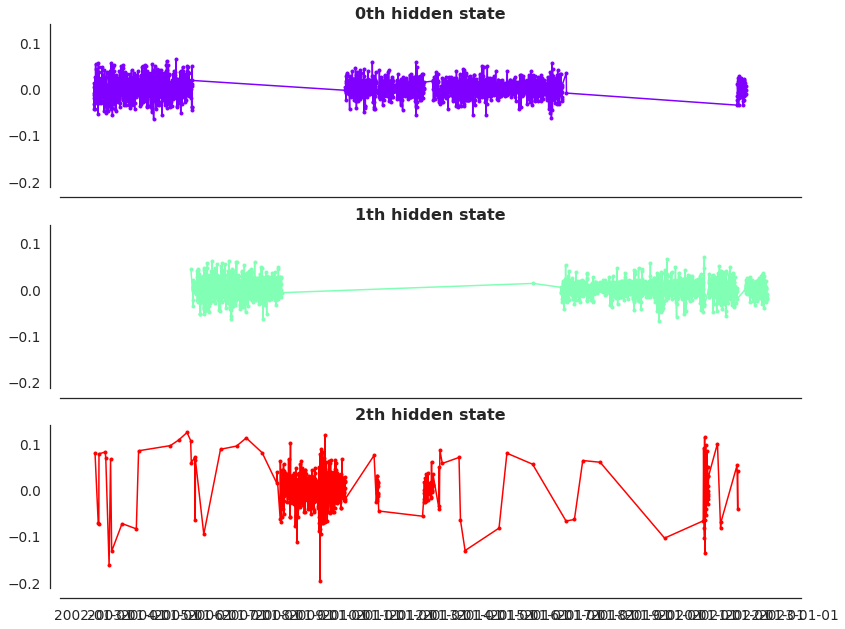

In [11]:
# code adapted from http://hmmlearn.readthedocs.io
# for sklearn 18.1

col = 'sret'
select = data.loc[:].dropna()

ft_cols = [f1, f2, f3, 'sret']
X = select[ft_cols].values

model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 1, 'ytick.major.size': 1,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(select.index.values[mask],
                 select[col].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)
plt.tight_layout()
fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')

        Date  states  TEDRATE  T10Y2Y  T10Y3M      AAPL      sret  mkt_cret
0 2002-01-03       0     0.18    1.97    3.43  0.360552  0.011946  0.011946
1 2002-01-04       0     0.18    1.99    3.46  0.362235  0.004656  0.016601
2 2002-01-07       0     0.21    2.01    3.41  0.350155 -0.033916 -0.017315
3 2002-01-08       0     0.19    2.03    3.42  0.345721 -0.012746 -0.030060
4 2002-01-09       0     0.19    2.07    3.42  0.331042 -0.043387 -0.073448


C:\Users\HP\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


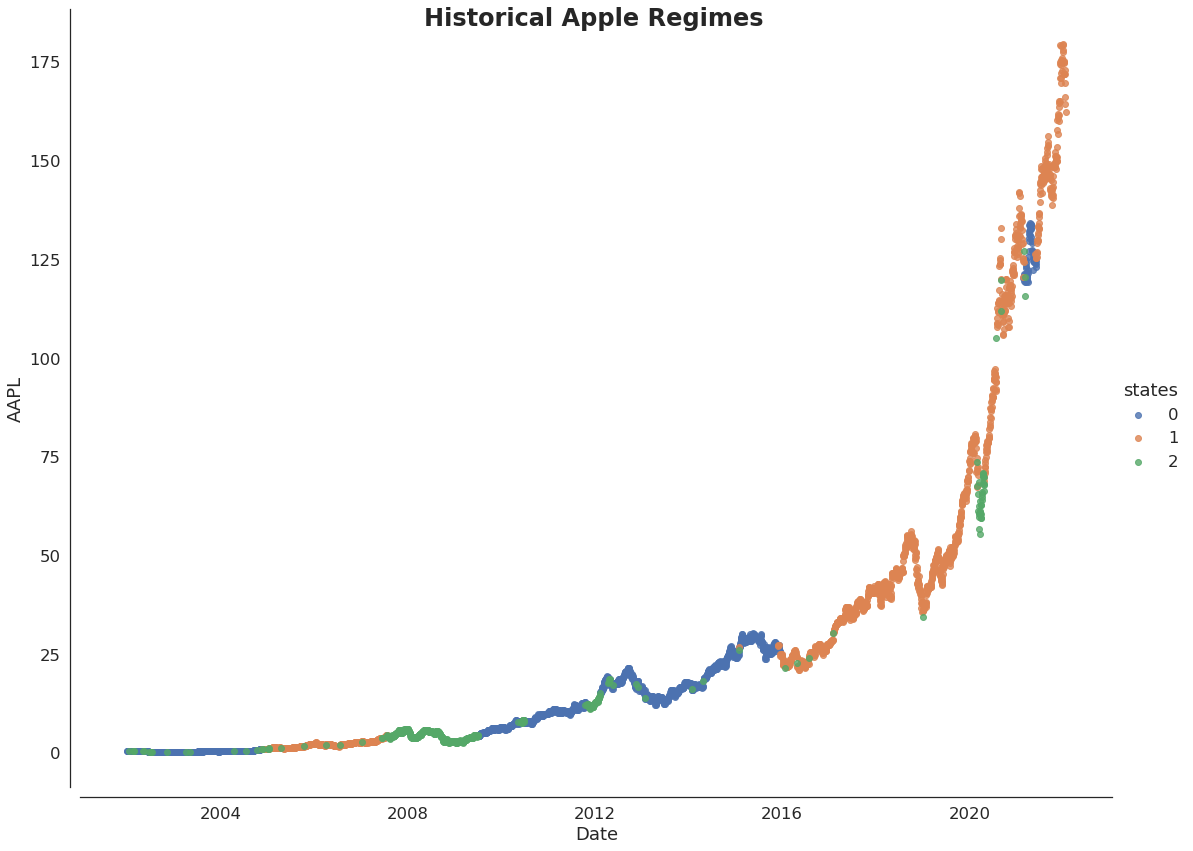

In [12]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=select.index)
          .join(select, how='inner')
          .assign(mkt_cret=select.sret.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
p(states.head())

sns.set_style('white', style_kwds)
order = [0, 1, 2]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order, aspect=1.31, size=12)
fg.map(plt.scatter, 'Date', mkt, alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical Apple Regimes', fontsize=24, fontweight='demi')
fg.savefig('Hidden Markov (Mixture) Model_AAPL Regimes.png')

## Finding Equillibrium Matrix

In [3]:
start = pd.to_datetime('2002-01-01')
end = pd.datetime.today()

df = web.DataReader("AAPL", 'yahoo', start, end)
df

C:\Users\HP\AppData\Local\Temp/ipykernel_13232/3560409931.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime.today()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-01-02,0.416071,0.392143,0.393750,0.416071,529496800.0,0.356271
2002-01-03,0.424107,0.406607,0.410714,0.421071,612007200.0,0.360552
2002-01-04,0.427679,0.410536,0.416786,0.423036,409976000.0,0.362235
2002-01-07,0.428571,0.406250,0.423571,0.408929,444584000.0,0.350155
2002-01-08,0.411607,0.401071,0.406250,0.403750,450038400.0,0.345721
...,...,...,...,...,...,...
2022-04-25,163.169998,158.460007,161.119995,162.880005,96046400.0,162.880005
2022-04-26,162.339996,156.720001,162.250000,156.800003,95623200.0,156.800003
2022-04-27,159.789993,155.380005,155.910004,156.570007,88063200.0,156.570007


In [4]:
df["state"]=df["Close"].astype(float).pct_change()
df['state']=df['state'].apply(lambda x: 'Upside' if (x > 0.001) else ('Downside' if (x<=0.001) else 'Consolidation'))
df

,High,Low,Open,Close,Volume,Adj Close,state
Date,,,,,,,
2002-01-02,0.416071,0.392143,0.393750,0.416071,529496800.0,0.356271,Consolidation
2002-01-03,0.424107,0.406607,0.410714,0.421071,612007200.0,0.360552,Upside
2002-01-04,0.427679,0.410536,0.416786,0.423036,409976000.0,0.362235,Upside
2002-01-07,0.428571,0.406250,0.423571,0.408929,444584000.0,0.350155,Downside
2002-01-08,0.411607,0.401071,0.406250,0.403750,450038400.0,0.345721,Downside
...,...,...,...,...,...,...,...
2022-04-25,163.169998,158.460007,161.119995,162.880005,96046400.0,162.880005,Upside
2022-04-26,162.339996,156.720001,162.250000,156.800003,95623200.0,156.800003,Downside
2022-04-27,159.789993,155.380005,155.910004,156.570007,88063200.0,156.570007,Downside


In [5]:
df['priorstate']=df['state'].shift(1)
df.tail()

,High,Low,Open,Close,Volume,Adj Close,state,priorstate
Date,,,,,,,,
2022-04-25,163.169998,158.460007,161.119995,162.880005,96046400.0,162.880005,Upside,Downside
2022-04-26,162.339996,156.720001,162.250000,156.800003,95623200.0,156.800003,Downside,Upside
2022-04-27,159.789993,155.380005,155.910004,156.570007,88063200.0,156.570007,Downside,Downside
2022-04-28,164.520004,158.929993,159.250000,163.639999,130216800.0,163.639999,Upside,Downside
2022-04-29,166.199997,157.250000,161.839996,157.649994,131587100.0,157.649994,Downside,Upside


# Transition Matrix for Markov Chain Model

In [6]:
df["state"]=df["Close"].astype(float).pct_change()
df['state']=df['state'].apply(lambda x: 'Upside' if (x > 0.001) else ('Downside' if (x<=0.001) else 'Consolidation'))

df['priorstate']=df['state'].shift(1)

states = df [['priorstate','state']].dropna()
states_matrix = states.groupby(['priorstate','state']).size().unstack().fillna(0)

transition_matrix= states_matrix.apply(lambda x: x/float(x.sum()),axis=1)
print(transition_matrix)

state          Downside    Upside
priorstate                       
Consolidation  0.000000  1.000000
Downside       0.495127  0.504873
Upside         0.508036  0.491964


In [7]:
df["state"]=df["Close"].astype(float).pct_change()
df['state']=df['state'].apply(lambda x: 'Upside' if (x > 0) else 'Downside' )

df['priorstate']=df['state'].shift(1)

states = df [['priorstate','state']].dropna()
states_matrix = states.groupby(['priorstate','state']).size().unstack().fillna(0)

transition_matrix= states_matrix.apply(lambda x: x/float(x.sum()),axis=1)
print(transition_matrix)

state       Downside    Upside
priorstate                    
Downside    0.469959  0.530041
Upside      0.479345  0.520655


In [8]:
t_0 = transition_matrix.copy()
t_1 =t_0.dot(t_0)
t_1

state,Downside,Upside
priorstate,,
Downside,0.474934,0.525066
Upside,0.474846,0.525154


In [9]:
t_0 = transition_matrix.copy()
t_1 =t_0.dot(t_0)
t_1

state,Downside,Upside
priorstate,,
Downside,0.474934,0.525066
Upside,0.474846,0.525154


In [ ]:
t_0 = transition_matrix.copy()
t_1 =t_0.dot(t_0)
t_365

In [ ]:
## Equilibrium Matrix using Python

In [10]:
## Equilibrium Matrix using Python

t_0 = transition_matrix.copy()

t_m = t_0.copy()
t_n = t_0.dot(t_0)

i = 1
while(not(t_m.equals(t_n))):
    i += 1
    t_m = t_n.copy()
    t_n = t_n.dot(t_0)

print("Equilibrium Matrix Number: " + str(i))
print(t_n)

Equilibrium Matrix Number: 9
state       Downside    Upside
priorstate                    
Downside    0.474888  0.525112
Upside      0.474888  0.525112


The equilibrium Matrix is a stationary state. So, As per the theory of the Markov Chain, This figure will stay the same for foreseeable data points

In [11]:
##Random Walk

symbol = "AAPL"
days = 10000
end_date = datetime.datetime.now().strftime("%d-%b-%Y")
end_date = str(end_date)

start_date = (datetime.datetime.now()- datetime.timedelta(days=days)).strftime("%d-%b-%Y")
start_date = str(start_date)

#df=index_history("SPY",start_date,end_date)
df = web.DataReader("AAPL", 'yahoo', start_date, end_date)

df["state"]=df["Close"].astype(float).pct_change()
df['state']=df['state'].apply(lambda x: 'Upside' if (x > 0) else 'Downside' )

df['priorstate']=df['state'].shift(1)

states = df [['priorstate','state']].dropna()
states_matrix = states.groupby(['priorstate','state']).size().unstack().fillna(0)

transition_matrix= states_matrix.apply(lambda x: x/float(x.sum()),axis=1)
t_0 = transition_matrix.copy()

t_m = t_0.copy()
t_n = t_0.dot(t_0)

i = 1
while(not(t_m.equals(t_n))):
    i += 1
    t_m = t_n.copy()
    t_n = t_n.dot(t_0)

print("Equilibrium Matrix Number: " + str(i))
print(t_n)

Equilibrium Matrix Number: 9
state       Downside    Upside
priorstate                    
Downside    0.487522  0.512478
Upside      0.487522  0.512478
